# W state on ibmq_singapore

In [1]:
# qiskit imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
from qiskit.qobj import QasmQobj
from qiskit.result import Result
import qiskit.quantum_info as qi
from qiskit.assembler import disassemble
from qiskit.visualization import circuit_drawer

# own code
import workinglib as wl
import likelihood_maximisation as lm
import partitioning as pt

# other tools
import json
import pickle
import numpy as np
import itertools as it
import more_itertools as mit
import matplotlib as plt

## Submitted circuits and simulation

We first load the data with the transpiled circuits as they were run on the physical device.

In [2]:
# LEFT
#### 0: Single partition and non-redundant negativity. (X)
#### 1: Very interesting structure. Non-trivial negativity-induced non-separability. (X)
#### 2: Highly connected.
#### 3: Sparse and highly separable.

# RIGHT
#### 0: Interesting structure. Non-trivial negativity-induced non-separability with multiple minimal partitions. (X)
#### 1: Negativity-induced non-separability between qubit 12 and largest component.
#### 2: Sparse and highly separable.
#### 3: Interesting structure. Single negativity merges two components. (X)

In [3]:
#Load input data
job_ids = {'left': ['5eb97c40cd2610001a9621fb', '5eb69289a86cf20018a66ec2',
                    '5eb5c0a0fce67a0012149e7b', '5eb5071e2260f90011e5d650'],
           'right': ['5eb5c064fce67a0012149e79', '5eb69250fce67a001214a66a',
                     '5eb97b806372c0001a1142d9', '5eb5085bfce67a00121497d3']}
side = 'right'
index = 0
job_id = job_ids[side][index]
with open(f'data/w_state/job-{job_id}/{job_id}-input.json', 'r') as read_file:
    input_data = json.load(read_file)

# Create qiskit QasmQobj with it
qobj = QasmQobj.from_dict(input_data)

/Users/guille/anaconda3/lib/python3.8/site-packages/qiskit/assembler/disassemble.py:133: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
  _inst = instr_method(*params, *qubits, *clbits)
/Users/guille/anaconda3/lib/python3.8/site-packages/qiskit/assembler/disassemble.py:133: DeprecationWarning: The QuantumCircuit.u2 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You can use the general 1-qubit gate QuantumCircuit.u instead: u2(φ,λ) = u(π/2, φ, λ). Alternatively, you can decompose it interms of QuantumCircuit.p and QuantumCircuit.sx: u2(φ,λ) = p(π/2+φ) sx p(π/2+λ) (1 pulse on hardware).
  _inst = instr_method(*params, *qubits,

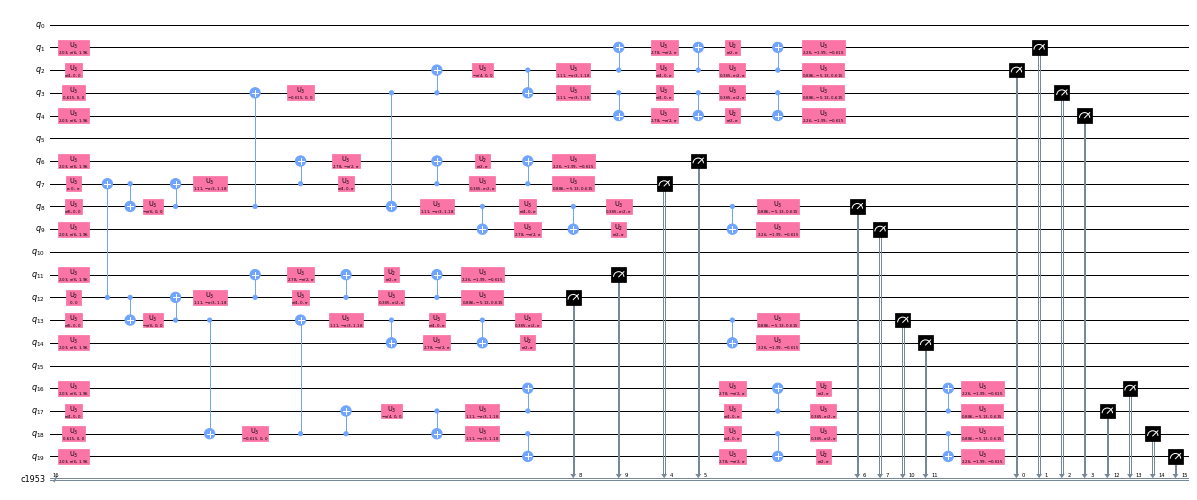

In [4]:
# Draw one of the circuits
dis_qobj = disassemble(qobj);
circuit_drawer(dis_qobj[0][0], scale=0.5, fold=-1, output='mpl')

In [5]:
# Define system-ancilla relation of POVM implementation
sys_anc = {'left': {7: 8, 12: 13, 6: 5, 11: 10, 1: 0, 16: 15, 2: 3, 17: 18},
           'right': {7: 6, 12: 11, 8: 9, 13: 14, 3: 4, 18: 19, 17: 16, 2: 1}}

To verify that the circuit prepares the W state and appends the SIC-POVM measurements, we simulate the circuit locally using Aer's qasm_simulator and reconstruct the state to compare it with the theoretical expectation.

Once verified, change the value of variable "simulate" to analyse the experimental data.

In [6]:
# Decide whether to generate simulated data from the circuit above or to use the experimental one
simulate = False

nshots = 8192
n_circuits = len(dis_qobj[0])
if simulate:
    job_sim = execute(dis_qobj[0], Aer.get_backend('qasm_simulator'), shots=nshots)
    result = job_sim.result()
else:
    with open(f'data/w_state/job-{job_id}/{job_id}-output.json', 'r') as read_file:
        experimental_data = json.load(read_file)
    result = Result.from_dict(experimental_data)

In [7]:
# Aggregate all counts
counts = {}
for i in range(20):
    p_counts = result.get_counts(i)
    for outcome in p_counts:
        if outcome not in counts:
            counts[outcome] = p_counts[outcome]
        else:
            counts[outcome] += p_counts[outcome]
print('Total shots:', sum(counts.values()))
print('Expected:   ', nshots * n_circuits)

Total shots: 163840
Expected:    163840


In [8]:
# Reconstruct all the k-qubit density matrices with k > 1
k_min = 2
k_max = 3
inferred_states = {}
for k in range(k_min, k_max+1):
    print('k =', k)
    print('-'*30)
    
    # Compute all marginal distributions and k-qubit effects
    marginals = wl.compute_all_simplified_marginals(counts, sorted(sys_anc[side]), k=k)
    observables = wl.generate_sicpovm_effects(k, order='Qiskit')

    # Tomographic reconstruction of all states
    inferred_states[k] = {}
    for kple in marginals:
        inferred_states[k][kple] = qi.DensityMatrix(lm.infer_state(marginals, kple, observables))
        if inferred_states[k][kple].is_valid():
            print(kple, '- OK')
        else:
            print('Warning: invalid state for', kple)

k = 2
------------------------------
(2, 3) - OK
(2, 7) - OK
(2, 8) - OK
(2, 12) - OK
(2, 13) - OK
(2, 17) - OK
(2, 18) - OK
(3, 7) - OK
(3, 8) - OK
(3, 12) - OK
(3, 13) - OK
(3, 17) - OK
(3, 18) - OK
(7, 8) - OK
(7, 12) - OK
(7, 13) - OK
(7, 17) - OK
(7, 18) - OK
(8, 12) - OK
(8, 13) - OK
(8, 17) - OK
(8, 18) - OK
(12, 13) - OK
(12, 17) - OK
(12, 18) - OK
(13, 17) - OK
(13, 18) - OK
(17, 18) - OK
k = 3
------------------------------
(2, 3, 7) - OK
(2, 3, 8) - OK
(2, 3, 12) - OK
(2, 3, 13) - OK
(2, 3, 17) - OK
(2, 3, 18) - OK
(2, 7, 8) - OK
(2, 7, 12) - OK
(2, 7, 13) - OK
(2, 7, 17) - OK
(2, 7, 18) - OK
(2, 8, 12) - OK
(2, 8, 13) - OK
(2, 8, 17) - OK
(2, 8, 18) - OK
(2, 12, 13) - OK
(2, 12, 17) - OK
(2, 12, 18) - OK
(2, 13, 17) - OK
(2, 13, 18) - OK
(2, 17, 18) - OK
(3, 7, 8) - OK
(3, 7, 12) - OK
(3, 7, 13) - OK
(3, 7, 17) - OK
(3, 7, 18) - OK
(3, 8, 12) - OK
(3, 8, 13) - OK
(3, 8, 17) - OK
(3, 8, 18) - OK
(3, 12, 13) - OK
(3, 12, 17) - OK
(3, 12, 18) - OK
(3, 13, 17) - OK
(3, 13, 18) 

3 qubit subset chosen: (2, 3, 17)


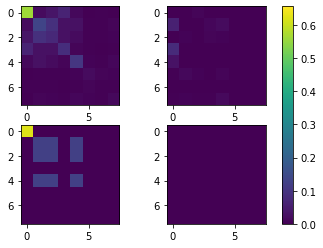

In [9]:
k = 3
k_reduced_index = 4
kple = sorted(inferred_states[k])[k_reduced_index]
print(k, "qubit subset chosen:", kple)

# Expected state
def partial_w(k, n):
    # k-qubit W state - collapse if vacuum measured in environment (p = k / N)
    kW_vec = np.zeros(2**k, dtype=complex)
    for i in range(k):
        kW_vec[2**i] = 1. / np.sqrt(k)
    # vacuum - collapse if excitation measured in environment (p = (n - k) / n)
    kv_vec = np.zeros(2**k, dtype=complex)
    kv_vec[0] = 1.
    # mixture of both
    rho = qi.DensityMatrix( (k / n) * np.outer(kW_vec, kW_vec.conj()) 
                            + (1. - k / n) * np.outer(kv_vec, kv_vec.conj()))
    return rho

# Plot simulation/experiment (top) vs expected result (bottom),
# separating real (left) and imaginary (right) parts

cb_lim = 1.05 * np.amax(np.real(partial_w(k, 8).data))
fig, ax =  plt.pyplot.subplots(2, 2);
im0 = ax[0][0].imshow(np.real(inferred_states[k][kple].data), norm=plt.colors.Normalize(0, cb_lim));
im1 = ax[0][1].imshow(np.imag(inferred_states[k][kple].data), norm=plt.colors.Normalize(0, cb_lim));
im2 = ax[1][0].imshow(np.real(partial_w(k, 8).data), norm=plt.colors.Normalize(0, cb_lim));
im3 = ax[1][1].imshow(np.imag(partial_w(k, 8).data), norm=plt.colors.Normalize(0, cb_lim));
fig.colorbar(im0, ax=ax);

## Entanglement structure

With the reconstructed states, we calculate the fidelity and entanglement monotones. We then compare the entanglement values to spurious entanglement in separable states.

In [10]:
# Calculate all quantities and show fidelity
fidelity = {}
entanglement = {}
exact_states = {}
new_index = {q: i for i, q in enumerate(sorted(sys_anc[side]))}
for k in inferred_states:
    print('k =', k)
    print('-'*30)
    fidelity[k] = {}
    entanglement[k] = {}
    exact_states[k] = {}
    for kple in sorted(inferred_states[k]):
        qubit_list = list(range(len(sys_anc[side])))
        for qubit in kple:
            qubit_list.remove(new_index[qubit])
        exact_states[k][kple] = qi.partial_trace(partial_w(8, 8), qubit_list) if len(kple) < 8 else partial_w(8, 8)
        fidelity[k][kple] = np.sqrt(qi.state_fidelity(inferred_states[k][kple], exact_states[k][kple]))
        for P in mit.set_partitions(kple, k=2):
            entanglement[k][(tuple(P[0]), tuple(P[1]))] = wl.negativity_list(inferred_states[k][kple].data, kple, P[0], order='Qiskit', atol=0.0) if k != 2 else qi.concurrence(inferred_states[k][kple])
        print(kple, fidelity[k][kple])

k = 2
------------------------------
(2, 3) 0.9370140959577937
(2, 7) 0.899070315705083
(2, 8) 0.9235555586466722
(2, 12) 0.9003118309275815
(2, 13) 0.9116153381049814
(2, 17) 0.9062999501982169
(2, 18) 0.8276240597831126
(3, 7) 0.9089151338977411
(3, 8) 0.9322169096493872
(3, 12) 0.9077712880529734
(3, 13) 0.9180547690942907
(3, 17) 0.924596250154412
(3, 18) 0.8503124563221092
(7, 8) 0.9306250869647259
(7, 12) 0.9066028359998494
(7, 13) 0.9231865125881097
(7, 17) 0.9114515307077593
(7, 18) 0.8326371666856835
(8, 12) 0.9318870359677801
(8, 13) 0.9374677461211495
(8, 17) 0.9298557432167412
(8, 18) 0.8594723625065694
(12, 13) 0.9376460755929104
(12, 17) 0.9079293741431044
(12, 18) 0.852928574205273
(13, 17) 0.9335662327294622
(13, 18) 0.8738840730182038
(17, 18) 0.876957052762147
k = 3
------------------------------
(2, 3, 7) 0.8554060626778083
(2, 3, 8) 0.8846211573697237
(2, 3, 12) 0.8549076974355319
(2, 3, 13) 0.8650606673907977
(2, 3, 17) 0.8608498384979122
(2, 3, 18) 0.7708147414466

In [11]:
# Calculate entanglemement: concurrence for k = 2, negativity for k > 2
for k in entanglement:
    print('k =', k)
    print('-'*30)
    for kple in sorted(entanglement[k], key=lambda x:min(len(x[0]), len(x[1])) if k>2 else x):
        print(kple, entanglement[k][kple])

k = 2
------------------------------
((2,), (3,)) 0.059958875474468154
((2,), (7,)) 0.0
((2,), (8,)) 0.0
((2,), (12,)) 0.0
((2,), (13,)) 0.0
((2,), (17,)) 0.0
((2,), (18,)) 0.0
((3,), (7,)) 0.0
((3,), (8,)) 0.0
((3,), (12,)) 0.0
((3,), (13,)) 0.0
((3,), (17,)) 0.0
((3,), (18,)) 0.0
((7,), (8,)) 0.0
((7,), (12,)) 0.0
((7,), (13,)) 0.0
((7,), (17,)) 0.0
((7,), (18,)) 0.0
((8,), (12,)) 0.0
((8,), (13,)) 0.1752176374521656
((8,), (17,)) 0.0
((8,), (18,)) 0.0
((12,), (13,)) 0.004769685085645514
((12,), (17,)) 0.0
((12,), (18,)) 0.0
((13,), (17,)) 0.0
((13,), (18,)) 0.0
((17,), (18,)) 0.0
k = 3
------------------------------
((2,), (3, 7)) 0.05355037309638784
((2, 3), (7,)) 0.0059149829936025675
((3,), (2, 7)) 0.05117313221914981
((2,), (3, 8)) 0.05539308077287494
((2, 3), (8,)) 0.009324673239425952
((3,), (2, 8)) 0.04644158267939808
((2,), (3, 12)) 0.041315000876580486
((2, 3), (12,)) 0.0012344039716411825
((3,), (2, 12)) 0.03989274050339972
((2,), (3, 13)) 0.04271308585027907
((2, 3), (13,

In [12]:
# Load distributions of spurious entanglement
negativities_filename = 'data/distributions/neg_res.pkl'
with open(negativities_filename,'rb') as file:
    negativities = pickle.load(file)

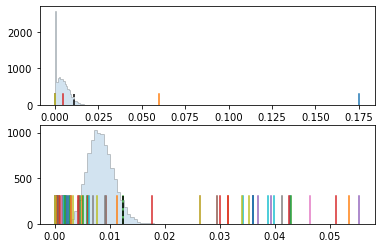

In [13]:
# Plot the results
p = 5e-2
h = 300

fig, ax =  plt.pyplot.subplots(2, 1);
kwargs = dict(histtype='stepfilled', alpha=0.2, density=False, bins=30, ec="k", lw=1, log=False)

# Concurrence
n_instances = len(negativities['00_11_state'])
thr = sorted(negativities['00_11_state'])[-int(n_instances * p)]
ax[0].hist(negativities['00_11_state'], **kwargs);
for kple in entanglement[2]:
    ax[0].plot([entanglement[2][kple], entanglement[2][kple]], [0, h])
ax[0].plot([thr, thr], [0, h], ls='--', c='k');

# 3-qubit negativity (1, 2)
n_instances = len(negativities['000_111_state']['100'])
thr = sorted(negativities['000_111_state']['100'])[-int(n_instances * p)]
ax[1].hist(negativities['000_111_state']['100'], **kwargs);
for kple in entanglement[3]:
    ax[1].plot([entanglement[3][kple], entanglement[3][kple]], [0, h])
ax[1].plot([thr, thr], [0, h], ls='--', c='k');

# # 4-qubit negativity (1, 3)
# n_instances = len(negativities['0011state']['0100'])
# thr = sorted(negativities['0011state']['0100'])[-int(n_instances * p)]
# ax[(1, 0)].hist(negativities['0011state']['0100'], **kwargs);
# for kple in entanglement[4]:
#     if min(len(kple[0]), len(kple[1])) == 1:
#         ax[(1, 0)].plot([entanglement[4][kple], entanglement[4][kple]], [0, h])
# ax[(1, 0)].plot([thr, thr], [0, h], ls='--', c='k');

# # 4-qubit negativity (2, 2)
# n_instances = len(negativities['0011state']['1100'])
# thr = sorted(negativities['0011state']['1100'])[-int(n_instances * p)]
# ax[(1, 1)].hist(negativities['0011state']['1100'], **kwargs);
# for kple in entanglement[4]:
#     if min(len(kple[0]), len(kple[1])) == 2:
#         ax[(1, 1)].plot([entanglement[4][kple], entanglement[4][kple]], [0, h])
# ax[(1, 1)].plot([thr, thr], [0, h], ls='--', c='k');

In [14]:
# Filter out the spurious observations
spurious_dist = {2: negativities['00_11_state'],
                 3: negativities['000_111_state']['100']}

stat_relevant = {}
for k in entanglement:
    stat_relevant[k] = []
    for red_part in entanglement[k]:
        if wl.p_value(entanglement[k][red_part], spurious_dist[k]) < p:
            stat_relevant[k].append([red_part[0], red_part[1]])

In [15]:
# Filter out redundant constraints
non_redundant = stat_relevant[2].copy()
all_constrain = stat_relevant[2].copy()
for t_bip in stat_relevant[3]:
    ta, tb = set(t_bip[0]), set(t_bip[1])
    add = True
    for b_bip in stat_relevant[2]:
        ba, bb = set(b_bip[0]), set(b_bip[1])
        if (ba.issubset(ta) and bb.issubset(tb)) or (ba.issubset(tb) and bb.issubset(ta)):
            add = False
            break
    if add:
        non_redundant.append(t_bip)
    all_constrain.append(t_bip)        

In [16]:
print("Non-redundant:  ", non_redundant)
print("All constraints:", all_constrain)

Non-redundant:   [[(2,), (3,)], [(8,), (13,)], [(12,), (7, 13)]]
All constraints: [[(2,), (3,)], [(8,), (13,)], [(2,), (3, 7)], [(3,), (2, 7)], [(2,), (3, 8)], [(3,), (2, 8)], [(2,), (3, 12)], [(3,), (2, 12)], [(2,), (3, 13)], [(3,), (2, 13)], [(2,), (3, 17)], [(3,), (2, 17)], [(2,), (3, 18)], [(3,), (2, 18)], [(2, 8), (13,)], [(8,), (2, 13)], [(3, 8), (13,)], [(8,), (3, 13)], [(7, 8), (13,)], [(8,), (7, 13)], [(12,), (7, 13)], [(8,), (12, 13)], [(8, 12), (13,)], [(8,), (13, 17)], [(13,), (8, 17)], [(8,), (13, 18)], [(13,), (8, 18)]]


In [17]:
part_non_red = pt.all_maximal_partitions(sorted(sys_anc[side]), non_redundant)
part_all_con = pt.all_maximal_partitions(sorted(sys_anc[side]), all_constrain)
print("Non-redundant:  ", part_non_red)
print("All constraints:", part_all_con)

Non-redundant:   [{2: 0, 3: 0, 7: 1, 8: 2, 12: 2, 13: 2, 17: 3, 18: 4}, {2: 0, 3: 0, 7: 1, 8: 2, 12: 1, 13: 2, 17: 3, 18: 4}]
All constraints: [{2: 0, 3: 0, 7: 1, 8: 2, 12: 2, 13: 2, 17: 3, 18: 4}, {2: 0, 3: 0, 7: 1, 8: 2, 12: 1, 13: 2, 17: 3, 18: 4}]
